In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook determines an e-distance for each perturbation relative to control cells to (relatively) quantify their magnitude ###

import h5py
import numpy as np
import pandas as pd
import nexusformat.nexus as nx
import tables
import scipy
import scanpy as sc
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as pl
%load_ext rpy2.ipython

# # Custom functions
# import sys
# sys.path.insert(1, '../src')
from scperturb import *

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.2.2 
2: package ‘datasets’ was built under R version 4.2.2 
3: package ‘utils’ was built under R version 4.2.2 
4: package ‘grDevices’ was built under R version 4.2.2 
5: package ‘graphics’ was built under R version 4.2.2 
6: package ‘stats’ was built under R version 4.2.2 


In [2]:
### things to vary to get better p-values and non-negative distances

## the control guide which things are assessed relative to (spend time picking good controls)
## assess # of control cells vs pertuabtion cells and vary the number of sampled cells in class imbalance
## look how big the radius of perturbation and control is in PC space and cutoff # of PCs used in dist calculation
## lower max variable features during to 500?


In [3]:
## Load in data ##
adata = sc.read('/home/ssobti/projects/mir_tud/010523_filtered_data/miR.integrated.qc_norm_scaled.dimred.clustered.gex.guide_assigned.h5ad')

Only considering the two last: ['.guide_assigned', '.h5ad'].
Only considering the two last: ['.guide_assigned', '.h5ad'].


In [4]:
adata.obs['guide'] = [adata.obs['guide'].iloc[idx] if x == 'NA' else x for idx, x in enumerate(list(adata.obs['miR.family']))]

In [5]:
#meta data prior to filtering
meta = adata.obs
meta.head()

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_1:AAACCCAAGGAGAGGC-1        miR     33954.0          5998  miR_1   
miR_1:AAACCCAAGGTAAACT-1        miR     31928.0          6868  miR_1   
miR_1:AAACCCACAACGATCT-1        miR     42785.0          7447  miR_1   
miR_1:AAACCCACACGATTCA-1        miR     58537.0          8039  miR_1   
miR_1:AAACCCACAGTCAACT-1        miR     31579.0          6580  miR_1   

                                   barcode                     guide  \
miR_1:AAACCCAAGGAGAGGC-1  AAACCCAAGGAGAGGC             miR-203a-3p.1   
miR_1:AAACCCAAGGTAAACT-1  AAACCCAAGGTAAACT                 miR-93-3p   
miR_1:AAACCCACAACGATCT-1  AAACCCACAACGATCT  miR-130-3p/301-3p/454-3p   
miR_1:AAACCCACACGATTCA-1  AAACCCACACGATTCA                 TuD_NC_18   
miR_1:AAACCCACAGTCAACT-1  AAACCCACAGTCAACT                  miR-147b   

                               lor         pvalue     adj_pvalue  max_umi  \
miR_1:AAACCCAAGGAGAGGC-1  5.453121  2.983000e-159  3.010603e-152     67.0   
miR_1:AAACCCAAGGTAAACT-1  6.012001  3.907611e-225  3.943769e-218     97.0   
miR_1:AAACCCACAACGATCT-1  5.864701  3.299362e-202  3.329893e-195     89.0   
miR_1:AAACCCACACGATTCA-1  5.859895  2.574602e-201  2.598426e-194     96.0   
miR_1:AAACCCACAGTCAACT-1  5.632808  3.564463e-178  3.597446e-171     71.0   

                          ...     m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  ...  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  ...  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  ...  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  ...  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  ...  0.216625  12.725683     1.851258   1.934498   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_1:AAACCCAAGGAGAGGC-1  -0.706696    8.576309                       2   
miR_1:AAACCCAAGGTAAACT-1  -0.565367    6.549110                       0   
miR_1:AAACCCACAACGATCT-1  -0.545712    8.844221                       0   
miR_1:AAACCCACACGATTCA-1  -0.541886   10.072262                       1   
miR_1:AAACCCACAGTCAACT-1  -0.664292    7.698154                       8   

                          seurat_clusters guide_group  \
miR_1:AAACCCAAGGAGAGGC-1               T2      target   
miR_1:AAACCCAAGGTAAACT-1               T0      target   
miR_1:AAACCCACAACGATCT-1               T0      target   
miR_1:AAACCCACACGATTCA-1          control     control   
miR_1:AAACCCACAGTCAACT-1               T8      target   

                                        miR.family  
miR_1:AAACCCAAGGAGAGGC-1             miR-203a-3p.1  
miR_1:AAACCCAAGGTAAACT-1                 miR-93-3p  
miR_1:AAACCCACAACGATCT-1  miR-130-3p/301-3p/454-3p  
miR_1:AAACCCACACGATTCA-1                        NA  
miR_1:AAACCCACAGTCAACT-1                  miR-147b  

[5 rows x 21 columns]

In [6]:
count_df = meta.groupby(by = ['guide']).size().reset_index(name = 'cells')
idxs = count_df.loc[:,'guide'].str.startswith('TuD')
type = ['control' if x is True else 'perturbation' for x in idxs]
count_df['type'] = type
count_df

guide  cells          type
0            TuD_NC_01   1665       control
1            TuD_NC_02     49       control
2            TuD_NC_03     80       control
3            TuD_NC_04     72       control
4            TuD_NC_05     57       control
..                 ...    ...           ...
350         miR-942-5p     57  perturbation
351          miR-95-3p     45  perturbation
352  miR-96-5p/1271-5p    158  perturbation
353          miR-99-3p     71  perturbation
354   miR-99-5p/100-5p     98  perturbation

[355 rows x 3 columns]

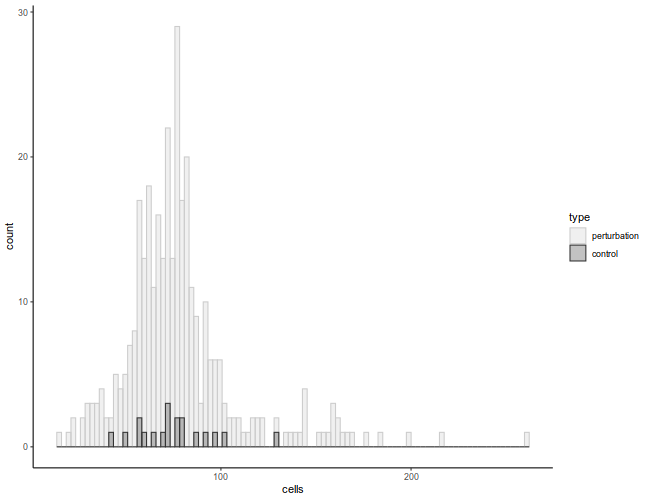

In [7]:
%%R -i count_df -w 650 -h 500
### data exploration of cells per perturbation with histogram

library(ggplot2)
count_df2 = count_df[!count_df$guide == 'TuD_NC_01',]
count_df2$type <- factor(count_df2$type, levels = c('perturbation', 'control'))

## without TuD_NC_01 which has 1687 cells
ggplot(count_df2, aes(x = cells, fill = type, color = type)) + 
geom_histogram(position = "identity", alpha = 0.3, bins = 100) + scale_color_grey(start = 0.8, end = 0.2) +
scale_fill_grey(start = 0.8, end = 0.2) + theme_classic()

In [8]:
# high class imbalance
adata = equal_subsampling(adata, 'guide', N_min=50)

In [9]:
adata.uns['processed'] = True

In [10]:
#meta data post-filtering
meta = adata.obs
meta

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_3:TGACTCCGTCGAGTGA-1        miR     57468.0          7408  miR_3   
miR_2:GGAACCCTCCTACAAG-1        miR     23409.0          5177  miR_2   
miR_3:GGTGAAGTCGAACGGA-1        miR     82751.0          8199  miR_3   
miR_1:AGCCACGCACCTCGTT-1        miR    144464.0         10285  miR_1   
miR_1:TCCACCACATCAGTCA-1        miR     31627.0          6387  miR_1   
...                             ...         ...           ...    ...   
miR_3:GCCTGTTAGATGCTAA-1        miR     91092.0          9554  miR_3   
miR_2:GCGTGCACATAATCGC-1        miR     29984.0          5777  miR_2   
miR_2:AGGATAATCGCAGTTA-1        miR     38137.0          6405  miR_2   
miR_3:GGAAGTGAGAGCTGCA-1        miR     74000.0          8895  miR_3   
miR_1:CGTGAATGTGATACCT-1        miR     29116.0          6215  miR_1   

                                   barcode        guide       lor  \
miR_3:TGACTCCGTCGAGTGA-1  TGACTCCGTCGAGTGA    TuD_NC_01  3.932891   
miR_2:GGAACCCTCCTACAAG-1  GGAACCCTCCTACAAG    TuD_NC_01  3.102560   
miR_3:GGTGAAGTCGAACGGA-1  GGTGAAGTCGAACGGA    TuD_NC_01  5.074465   
miR_1:AGCCACGCACCTCGTT-1  AGCCACGCACCTCGTT    TuD_NC_01  3.214156   
miR_1:TCCACCACATCAGTCA-1  TCCACCACATCAGTCA    TuD_NC_01  1.060372   
...                                    ...          ...       ...   
miR_3:GCCTGTTAGATGCTAA-1  GCCTGTTAGATGCTAA  miR-4742-3p  1.380606   
miR_2:GCGTGCACATAATCGC-1  GCGTGCACATAATCGC  miR-4742-3p  0.671712   
miR_2:AGGATAATCGCAGTTA-1  AGGATAATCGCAGTTA  miR-4742-3p  6.441211   
miR_3:GGAAGTGAGAGCTGCA-1  GGAAGTGAGAGCTGCA  miR-4742-3p  6.882166   
miR_1:CGTGAATGTGATACCT-1  CGTGAATGTGATACCT  miR-4742-3p  6.066587   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_3:TGACTCCGTCGAGTGA-1   2.261580e-49   1.810958e-42     52.0  ...   
miR_2:GGAACCCTCCTACAAG-1   1.369852e-39   1.425708e-32     35.0  ...   
miR_3:GGTGAAGTCGAACGGA-1  5.135852e-102   4.112528e-95     98.0  ...   
miR_1:AGCCACGCACCTCGTT-1   8.024023e-34   8.098272e-27     37.0  ...   
miR_1:TCCACCACATCAGTCA-1   1.829491e-13   1.846420e-06     13.0  ...   
...                                 ...            ...      ...  ...   
miR_3:GCCTGTTAGATGCTAA-1  1.326897e-318  1.062512e-311    152.0  ...   
miR_2:GCGTGCACATAATCGC-1   7.755481e-08   8.071713e-01      2.0  ...   
miR_2:AGGATAATCGCAGTTA-1  4.940656e-324  5.142113e-317    135.0  ...   
miR_3:GGAAGTGAGAGCTGCA-1  4.940656e-324  3.956226e-317    300.0  ...   
miR_1:CGTGAATGTGATACCT-1  5.291763e-230  5.340730e-223     94.0  ...   

                             m_umi       v_umi  log_max_umi  log_n_umi  \
miR_3:TGACTCCGTCGAGTGA-1  0.360202    6.993665     1.716003   2.155336   
miR_2:GGAACCCTCCTACAAG-1  0.161209    3.160815     1.544068   1.806180   
miR_3:GGTGAAGTCGAACGGA-1  0.544081   24.349693     1.991226   2.334454   
miR_1:AGCCACGCACCTCGTT-1  0.221662    3.546701     1.568202   1.944483   
miR_1:TCCACCACATCAGTCA-1  0.080605    0.483385     1.113943   1.505150   
...                            ...         ...          ...        ...   
miR_3:GCCTGTTAGATGCTAA-1  0.836272   71.556459     2.181844   2.521138   
miR_2:GCGTGCACATAATCGC-1  0.012594    0.017518     0.301030   0.698970   
miR_2:AGGATAATCGCAGTTA-1  0.460957   45.976376     2.130334   2.262451   
miR_3:GGAAGTGAGAGCTGCA-1  1.002519  226.563125     2.477121   2.599883   
miR_1:CGTGAATGTGATACCT-1  0.309824   22.295181     1.973128   2.089905   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_3:TGACTCCGTCGAGTGA-1  -0.443454    7.002158                       1   
miR_2:GGAACCCTCCTACAAG-1  -0.792611    6.736725                       7   
miR_3:GGTGAAGTCGAACGGA-1  -0.264337    6.943723                       7   
miR_1:AGCCACGCACCTCGTT-1  -0.654308    4.953483                       7   
miR_1:TCCACCACATCAGTCA-1  -1.093641    5.280298                       5   
...                             ...         ...                     ...   
miR_3:GCCTGTTAGATGCTAA-1  -0.077652    7.151012     

# E-distance

In [11]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'guide', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████| 317/317 [01:58<00:00,  2.67it/s]


In [12]:
# Compute E-distances
estats = edist(adata, obs_key='guide', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [13]:
# square matrix, all pairs of perturbations get an e-distance
estats.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_estats_mtx_separate_controls.csv')
estats.head()

TuD_NC_01  miR-34-5p/449-5p  \
TuD_NC_01                  0.000000         -4.970256   
miR-34-5p/449-5p          -4.970256          0.000000   
miR-130-3p/301-3p/454-3p  -4.389234         14.700329   
miR-28-5p/708-5p           3.451681         11.196277   
miR-183-3p                -6.150347         -4.252788   

                          miR-130-3p/301-3p/454-3p  miR-28-5p/708-5p  \
TuD_NC_01                                -4.389234          3.451681   
miR-34-5p/449-5p                         14.700329         11.196277   
miR-130-3p/301-3p/454-3p                  0.000000         -4.183146   
miR-28-5p/708-5p                         -4.183146          0.000000   
miR-183-3p                               -0.910823         -6.970287   

                          miR-183-3p  miR-641/3617-5p  miR-30c-3p/6788-5p  \
TuD_NC_01                  -6.150347       -11.840411           -8.438918   
miR-34-5p/449-5p           -4.252788        13.892768            8.212590   
miR-130-3p/301-3p/454-3p   -0.910823       -16.271718           -0.909023   
miR-28-5p/708-5p           -6.970287        -5.327853           -0.471657   
miR-183-3p                  0.000000        -9.028055           -3.996257   

                          let-7a-3p/let-7b-3p/let-7f-1-3p/98-3p  \
TuD_NC_01                                            -13.963540   
miR-34-5p/449-5p                                      -5.872154   
miR-130-3p/301-3p/454-3p                              -9.177833   
miR-28-5p/708-5p                                      -3.677511   
miR-183-3p                                           -19.225982   

                          miR-15-5p/16-5p/195-5p/424-5p/497-5p  \
TuD_NC_01                                            -1.724732   
miR-34-5p/449-5p                                     12.601873   
miR-130-3p/301-3p/454-3p                            -18.472433   
miR-28-5p/708-5p                                      0.264316   
miR-183-3p                                            3.854587   

                          miR-200bc-3p/429  ...  miR-877-3p  miR-361-3p  \
TuD_NC_01                        -2.940286  ...    7.632765   -1.936909   
miR-34-5p/449-5p                 -1.586740  ...   -1.933663   -7.291197   
miR-130-3p/301-3p/454-3p         -4.031310  ...    0.887827   -1.516996   
miR-28-5p/708-5p                -20.769539  ...  -17.920369  -10.473549   
miR-183-3p                       -7.701869  ...   -5.952393  -16.903613   

                          miR-339-5p   miR-1248  miR-33-5p  miR-196-5p  \
TuD_NC_01                  -0.692621  -0.790486  -3.914232    1.135299   
miR-34-5p/449-5p            6.891957   3.597258  19.188276   22.798533   
miR-130-3p/301-3p/454-3p   -4.674525  -7.317993 -11.779514  -13.581389   
miR-28-5p/708-5p            4.217875   6.327396   6.824203    5.034424   
miR-183-3p                -12.584867 -10.725589   6.698177    5.740403   

                          let-7f-2-3p/1185-3p  miR-191-5p  miR-660-5p  \
TuD_NC_01                           -5.770259  -11.558736   -4.628482   
miR-34-5p/449-5p                    16.145419    6.341947   -9.743391   
miR-130-3p/301-3p/454-3p           -22.492729   -7.525252   23.553512   
miR-28-5p/708-5p                     2.510400    4.782951   27.054802   
miR-183-3p                          -5.345947   -8.515363   -4.445026   

                          miR-4742-3p  
TuD_NC_01                  -13.206272  
miR-34-5p/449-5p            16.880588  
miR-130-3p/301-3p/454-3p   -15.692131  
miR-28-5p/708-5p             2.306410  
miR-183-3p                  -1.690113  

[5 rows x 317 columns]

E-distance relative to control KD (plotted better in R below)

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


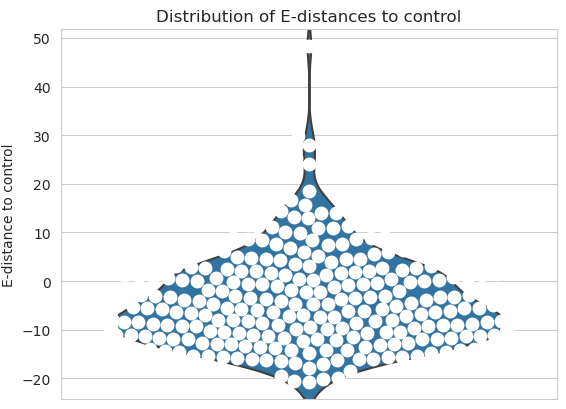

In [14]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['TuD_NC_04'], inner=None)
    sns.swarmplot(data=estats.loc['TuD_NC_04'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




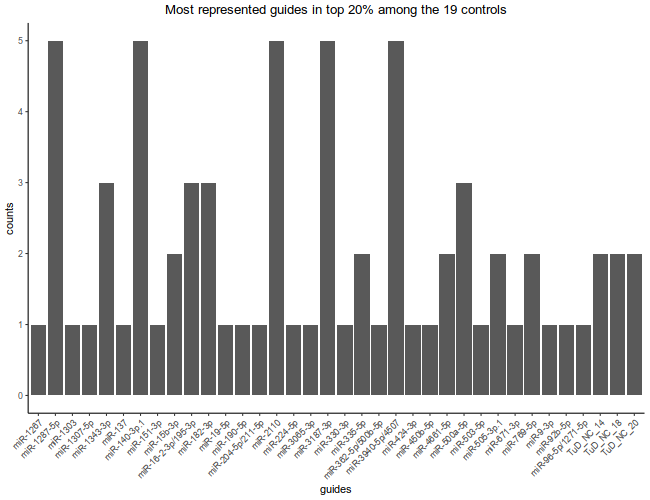

In [15]:
%%R -i estats -w 650 -h 500
library(stringr)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(dplyr)

## draw barplots showing distances of the perturbations to each of the controls
## capture top 20% furthest guides from each of the controls

startsWith(colnames(estats), prefix = 'TuD') -> status
names <- rownames(estats)[status]
tp20_pct = rep(list(matrix(0,5,5)), length(names))
dotplot = rep(list(matrix(0,5,5)), length(names))
for (i in 1:length(names)){
  startsWith(colnames(estats), prefix = 'TuD') -> status
  control_status = 1:length(status)
  control_status[status] <- 'control'
  control_status[!status] <- 'perturbation'
  estats_control1 <- data.frame(comparison_to_control_NC1 = estats[,names[i]], guide = control_status, guide_nm = rownames(estats))
  estats_control1 <- estats_control1[order(estats_control1$guide, decreasing = TRUE),]
  estats_control1$guide <- factor(estats_control1$guide, levels = c('perturbation', 'control'))
  tp20_pct[[i]] <- as.character(estats_control1[order(estats_control1$comparison_to_control_NC1, decreasing = TRUE),"guide_nm"][1:ceiling(0.2*nrow(estats_control1))])
  dotplot[[i]] = ggplot(estats_control1, aes(x = 1, y=comparison_to_control_NC1, fill = guide)) + 
    geom_dotplot(binaxis='y', stackdir='center',
                 stackratio=1.5, dotsize=1.2, binwidth = 0.5) + scale_fill_viridis_d() + 
    geom_text_repel(aes(y = comparison_to_control_NC1, x = 1, label = guide_nm),
                    xlim = c(0, 0.95), 
                    direction = "y") +
    theme_classic() + ylab('E-distance to TuD_NC') + xlab('') + ggtitle(names[i])
}

names(dotplot) <- names

## given that each of the top 20% of guides are different based on
## which control you're comparing to, we take top 20% guides from 5 sampled controls
## and find intersecting guides among the 5.
## we repeat this process 10 times (hopefully drawing different controls each time) 
## and draw a histogram to find most common guides

set.seed(44)
nms_list = replicate(10, Reduce(intersect, sample(tp20_pct, 5, replace = FALSE)))
nms = unlist(nms_list)
df = data.frame(guides = nms)
df = count(df, guides, name = 'counts')

barpl <- ggplot(df, aes(x = guides, y = counts)) + geom_col() + theme_classic() + ggtitle('Most represented guides in top 20% among the 19 controls') +
  theme(axis.text.x = element_text(angle = 45, hjust=1), plot.title = element_text(hjust = 0.5)) 


pdf('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_perturbs_to_varying_controls.pdf', height = 4, width = 5)
print(barpl)
for (i in 1:length(names)){
  print(dotplot[[i]])
}
dev.off()

barpl

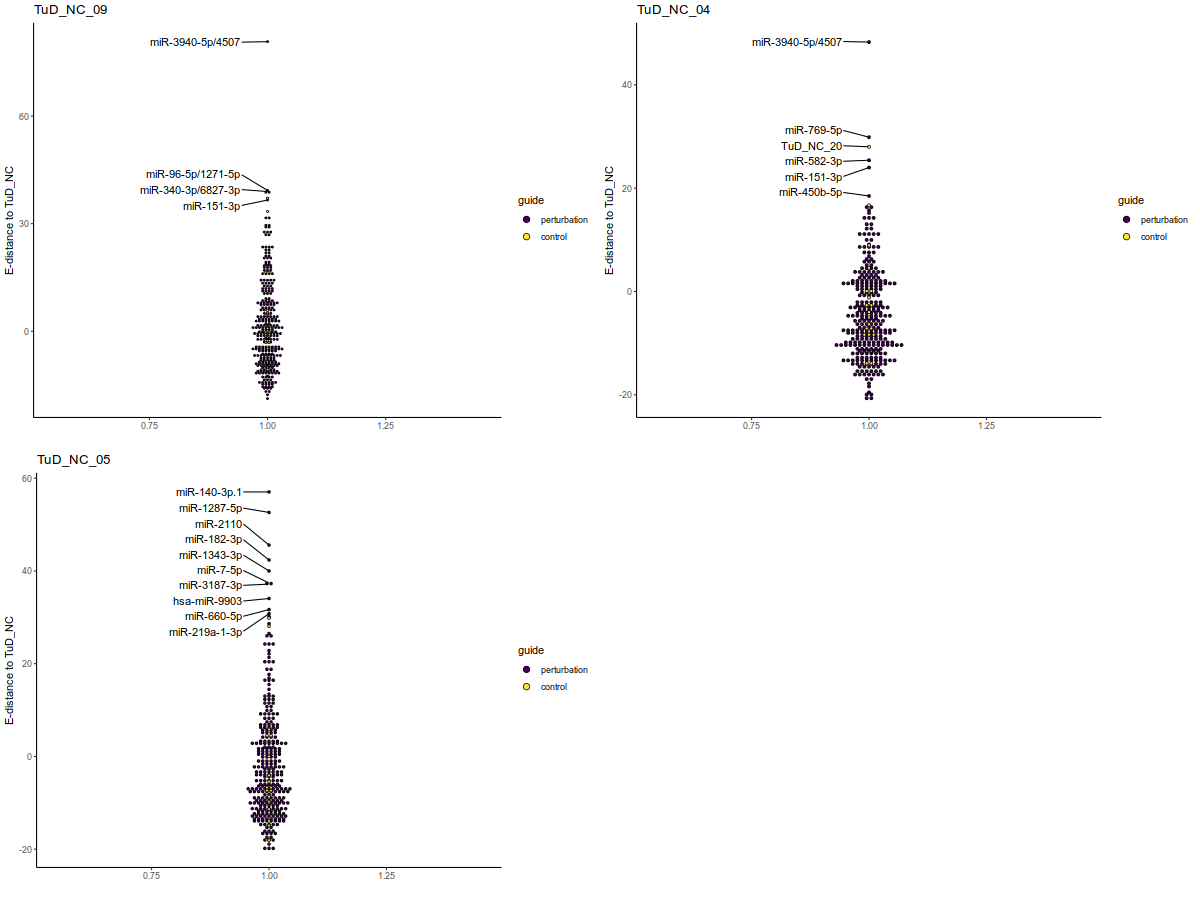

In [16]:
%%R -w 1200 -h 900
## representative controls for barplot above
controls_to_plot <- c('TuD_NC_09', 'TuD_NC_04', 'TuD_NC_05', 'TuD_NC_02')
ggarrange(plotlist = dotplot[controls_to_plot], nrow = 2, ncol = 2)


Heatmap of pariwise E-distances of perturbations to each other

In [17]:
## in this heatmap a lighter color means a perturbation is further away from another perturbation
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100])
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_separate_controls.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [18]:
## better color scheme
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100], cmap="vlag", vmin = -10, vmax = 10, cbar_kws={"ticks":[-10, -5,  0, 5,  10]})
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_edist_heatmap_color2_separate_controls.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# E-testing (p-value calculation)

In [19]:
## perform e-testing using each control guide (slow ~ 5hrs)
# e-testing -- here's what it's doing based on the paper:
## pvalue is found by combining the control cells and pertubation cells and switching their control/perturbation labels
## randomly 100 times to see how many times one gets a distance larger than when using the true original labels
## p-values are then adjusted using the Holm-Sidak method for multiple comparisons
ctrls = pd.Series(list(set(meta.loc[:,'guide'])))
ctrls = ctrls[ctrls.str.startswith('TuD')].sort_values().reset_index(drop=True)
prep_dict = dict(zip(ctrls, [0 for x in ctrls]))

for x in ctrls:
    prep_dict[x] = etest(adata, obs_key='guide', obsm_key='X_pca', dist='sqeuclidean', control=x, alpha=0.05, runs=100)

100%|██████████| 100/100 [07:02<00:00,  4.22s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [07:20<00:00,  4.40s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [06:45<00:00,  4.06s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [06:44<00:00,  4.05s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
100%|██████████| 100/100 [06:40<00:00,  4.01s/it]
/home/ssobti/miniconda3/envs/mirtud_env/li

In [20]:
import shelve
filenm = '/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_prep_dict_controls_separate.out'
my_shelf = shelve.open(filenm,'n') # 'n' for new
vec = ['estats', 'prep_dict', 'ctrls']
for key in vec:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
    except pickle.PicklingError:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

In [21]:
## load saved data
import shelve
filenm = '/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_prep_dict_controls_separate.out'
my_shelf = shelve.open(filenm)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [22]:
## pull out pvalues in prep_dict for each control run and put into a new df (pvals_df)
pvals_df = pd.DataFrame()
for x in ctrls:
    try:
        pvals_df.loc[:,x] = prep_dict[x].loc[:, 'pvalue']
    except KeyError:
        print(x + ' was not calculated')

In [23]:
pvals_df

TuD_NC_01  TuD_NC_03  TuD_NC_04  TuD_NC_05  TuD_NC_06  \
TuD_NC_01               0.00       0.96       0.46       0.55       0.81   
TuD_NC_03               0.92       0.00       0.95       0.66       0.85   
TuD_NC_04               0.53       0.96       0.00       0.28       0.95   
TuD_NC_05               0.54       0.69       0.19       0.00       0.75   
TuD_NC_06               0.86       0.85       0.91       0.67       0.00   
...                      ...        ...        ...        ...        ...   
miR-942-3p              0.52       0.86       0.87       0.90       0.93   
miR-942-5p              0.78       0.77       0.23       0.18       0.67   
miR-96-5p/1271-5p       0.44       0.51       0.13       0.10       0.35   
miR-99-3p               0.15       0.10       0.43       0.27       0.29   
miR-99-5p/100-5p        0.37       0.78       0.55       0.89       0.95   

                   TuD_NC_07  TuD_NC_08  TuD_NC_09  TuD_NC_10  TuD_NC_11  \
TuD_NC_01               0.35       0.76       0.13       0.42       0.15   
TuD_NC_03               0.57       0.96       0.26       0.64       0.18   
TuD_NC_04               0.70       0.71       0.71       0.48       0.20   
TuD_NC_05               0.93       0.83       0.26       0.80       0.29   
TuD_NC_06               0.89       0.82       0.29       0.69       0.21   
...                      ...        ...        ...        ...        ...   
miR-942-3p              0.98       0.83       0.48       0.98       0.45   
miR-942-5p              0.22       0.75       0.02       0.42       0.13   
miR-96-5p/1271-5p       0.27       0.37       0.01       0.18       0.05   
miR-99-3p               0.95       0.17       0.55       0.42       0.52   
miR-99-5p/100-5p        0.94       0.54       0.20       1.00       0.33   

                   TuD_NC_12  TuD_NC_14  TuD_NC_15  TuD_NC_16  TuD_NC_17  \
TuD_NC_01               0.23       0.17       0.29       0.48       0.51   
TuD_NC_03               0.55       0.13       0.61       0.74       0.69   
TuD_NC_04               0.70       0.77       0.29       0.68       0.15   
TuD_NC_05               0.62       0.03       0.72       0.71       0.67   
TuD_NC_06               0.58       0.42       0.45       0.96       0.54   
...                      ...        ...        ...        ...        ...   
miR-942-3p              0.86       0.24       0.76       0.75       0.59   
miR-942-5p              0.10       0.03       0.47       0.22       0.85   
miR-96-5p/1271-5p       0.05       0.02       0.20       0.15       0.88   
miR-99-3p               0.63       0.21       0.40       0.82       0.01   
miR-99-5p/100-5p        0.74       0.07       0.39       0.83       0.65   

                   TuD_NC_18  TuD_NC_19  TuD_NC_20  
TuD_NC_01               0.13       0.74       0.10  
TuD_NC_03               0.18       0.92       0.24  
TuD_NC_04               0.61       0.47       0.07  
TuD_NC_05               0.02       0.99       0.92  
TuD_NC_06               0.38       0.78       0.12  
...                      ...        ...        ...  
miR-942-3p              0.23       0.99       0.34  
miR-942-5p              0.02       0.56       0.26  
miR-96-5p/1271-5p       0.00       0.48       0.07  
miR-99-3p               0.04       0.19       0.02  
miR-99-5p/100-5p        0.07       0.92       0.55  

[317 rows x 18 columns]

In [24]:
## convert p-vals across rows (ie the comparison of each guide to the 20 controls) to z-scores
## make all p-vals of 0 equal to 0.001
pvals_df[pvals_df == 0] = 0.001
pvals_df[pvals_df == 1] = 0.999
z_scores_df = pvals_df.copy()
import scipy as sp
import math
for index, row in pvals_df.iterrows():
    z_scores_df.loc[index,:] = sp.stats.norm.ppf(1 - row)

In [25]:
## calculate combined zscores

def combine_zscores(scores):
    return sum(scores)/np.sqrt(len(scores))

zscores_comb = z_scores_df.apply(combine_zscores, axis = 1)

In [26]:
z_scores_df

TuD_NC_01  TuD_NC_03  TuD_NC_04  TuD_NC_05  TuD_NC_06  \
TuD_NC_01           3.090232  -1.750686   0.100434  -0.125661  -0.877896   
TuD_NC_03          -1.405072   3.090232  -1.644854  -0.412463  -1.036433   
TuD_NC_04          -0.075270  -1.750686   3.090232   0.582842  -1.644854   
TuD_NC_05          -0.100434  -0.495850   0.877896   3.090232  -0.674490   
TuD_NC_06          -1.080319  -1.036433  -1.340755  -0.439913   3.090232   
...                      ...        ...        ...        ...        ...   
miR-942-3p         -0.050154  -1.080319  -1.126391  -1.281552  -1.475791   
miR-942-5p         -0.772193  -0.738847   0.738847   0.915365  -0.439913   
miR-96-5p/1271-5p   0.150969  -0.025069   1.126391   1.281552   0.385320   
miR-99-3p           1.036433   1.281552   0.176374   0.612813   0.553385   
miR-99-5p/100-5p    0.331853  -0.772193  -0.125661  -1.226528  -1.644854   

                   TuD_NC_07  TuD_NC_08  TuD_NC_09  TuD_NC_10  TuD_NC_11  \
TuD_NC_01           0.385320  -0.706303   1.126391   0.201893   1.036433   
TuD_NC_03          -0.176374  -1.750686   0.643345  -0.358459   0.915365   
TuD_NC_04          -0.524401  -0.553385  -0.553385   0.050154   0.841621   
TuD_NC_05          -1.475791  -0.954165   0.643345  -0.841621   0.553385   
TuD_NC_06          -1.226528  -0.915365   0.553385  -0.495850   0.806421   
...                      ...        ...        ...        ...        ...   
miR-942-3p         -2.053749  -0.954165   0.050154  -2.053749   0.125661   
miR-942-5p          0.772193  -0.674490   2.053749   0.201893   1.126391   
miR-96-5p/1271-5p   0.612813   0.331853   2.326348   0.915365   1.644854   
miR-99-3p          -1.644854   0.954165  -0.125661   0.201893  -0.050154   
miR-99-5p/100-5p   -1.554774  -0.100434   0.841621  -3.090232   0.439913   

                   TuD_NC_12  TuD_NC_14  TuD_NC_15  TuD_NC_16  TuD_NC_17  \
TuD_NC_01           0.738847   0.954165   0.553385   0.050154  -0.025069   
TuD_NC_03          -0.125661   1.126391  -0.279319  -0.643345  -0.495850   
TuD_NC_04          -0.524401  -0.738847   0.553385  -0.467699   1.036433   
TuD_NC_05          -0.305481   1.880794  -0.582842  -0.553385  -0.439913   
TuD_NC_06          -0.201893   0.201893   0.125661  -1.750686  -0.100434   
...                      ...        ...        ...        ...        ...   
miR-942-3p         -1.080319   0.706303  -0.706303  -0.674490  -0.227545   
miR-942-5p          1.281552   1.880794   0.075270   0.772193  -1.036433   
miR-96-5p/1271-5p   1.644854   2.053749   0.841621   1.036433  -1.174987   
miR-99-3p          -0.331853   0.806421   0.253347  -0.915365   2.326348   
miR-99-5p/100-5p   -0.643345   1.475791   0.279319  -0.954165  -0.385320   

                   TuD_NC_18  TuD_NC_19  TuD_NC_20  
TuD_NC_01           1.126391  -0.643345   1.281552  
TuD_NC_03           0.915365  -1.405072   0.706303  
TuD_NC_04          -0.279319   0.075270   1.475791  
TuD_NC_05           2.053749  -2.326348  -1.405072  
TuD_NC_06           0.305481  -0.772193   1.174987  
...                      ...        ...        ...  
miR-942-3p          0.738847  -2.326348   0.412463  
miR-942-5p          2.053749  -0.150969   0.643345  
miR-96-5p/1271-5p   3.090232   0.050154   1.475791  
miR-99-3p           1.750686   0.877896   2.053749  
miR-99-5p/100-5p    1.475791  -1.405072  -0.125661  

[317 rows x 18 columns]

In [27]:
zscores_comb

TuD_NC_01            1.535892
TuD_NC_03           -0.550739
TuD_NC_04            0.139885
TuD_NC_05           -0.248899
TuD_NC_06           -0.731222
                       ...   
miR-942-3p          -3.077670
miR-942-5p           2.051198
miR-96-5p/1271-5p    4.188015
miR-99-3p            2.313931
miR-99-5p/100-5p    -1.693274
Length: 317, dtype: float64

In [28]:
mean_distances = estats.loc[z_scores_df.index, estats.columns.str.startswith('TuD')].mean(axis = 1)

In [29]:
## convert zscores_comb to pvalues and remove control guides from results
## remove control guides
p_vals_combined = 1 - sp.stats.norm.cdf(zscores_comb)
df_dict = {'guide' : zscores_comb.index, 'edist': mean_distances, 'pvalue_adj' : p_vals_combined}
df = pd.DataFrame(df_dict)
df = df.drop(df[df['guide'].str.startswith('TuD')].index)
df = df.reset_index(drop = True)
df['significant_adj'] = df['pvalue_adj'] < 0.05
df = df.set_index('guide')
df.index.name = None
df

edist  pvalue_adj  significant_adj
hsa-miR-10399-3p   -2.272047    0.704555            False
hsa-miR-10399-5p    7.506643    0.002432             True
hsa-miR-10523-5p    1.544619    0.199713            False
hsa-miR-10526-3p   -0.779381    0.528644            False
hsa-miR-10527-5p   -3.990798    0.932711            False
...                      ...         ...              ...
miR-942-3p         -6.981226    0.998957            False
miR-942-5p          5.143459    0.020124             True
miR-96-5p/1271-5p  13.220338    0.000014             True
miR-99-3p           5.909182    0.010336             True
miR-99-5p/100-5p   -4.582004    0.954798            False

[299 rows x 3 columns]

df.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_df_separate_controls.csv')

In [31]:
df = pd.read_csv('/home/ssobti/projects/mir_tud/output_data/edist/updated_inputs/miR_etest_df_separate_controls.csv', index_col=0)
df.sort_values('pvalue_adj')
df.sort_values('pvalue_adj').iloc[0:20,:]

edist    pvalue_adj  significant_adj
miR-140-3p.1        38.055410  2.220446e-16             True
miR-1287-5p         32.314464  2.831069e-14             True
miR-2110            31.377489  2.604361e-12             True
miR-3940-5p/4507    32.615121  3.557599e-12             True
miR-182-3p          25.221713  5.769996e-11             True
miR-1343-3p         24.270018  1.747685e-10             True
miR-7-5p            22.509437  3.845386e-10             True
hsa-miR-9903        20.196624  1.306778e-09             True
miR-3187-3p         21.450807  5.991877e-08             True
miR-660-5p          16.815627  8.784801e-08             True
miR-582-3p          16.586072  1.850954e-07             True
miR-500a-5p         14.892137  1.932574e-07             True
miR-137             16.978066  2.098822e-07             True
miR-16-2-3p/195-3p  16.288545  2.178324e-07             True
miR-331-3p          13.551965  5.478547e-07             True
miR-204-5p/211-5p   15.599658  7.473733e-07             True
miR-9-3p            14.243091  1.000310e-06             True
miR-769-5p          17.156797  1.712570e-06             True
miR-15b-3p          14.124571  6.859983e-06             True
miR-505-5p          13.613501  6.987472e-06             True

In [32]:
df.sort_values('pvalue_adj').iloc[-5:-1,:]

edist  pvalue_adj  significant_adj
miR-744-3p                          -8.472566    0.999659            False
miR-25-3p/32-5p/92-3p/363-3p/367-3p -7.871014    0.999662            False
miR-33b-3p/515-3p/519e-3p           -7.807185    0.999884            False
miR-589-5p                          -8.786526    0.999919            False

### Scatter plot of E-distance from control vs adjusted p-value

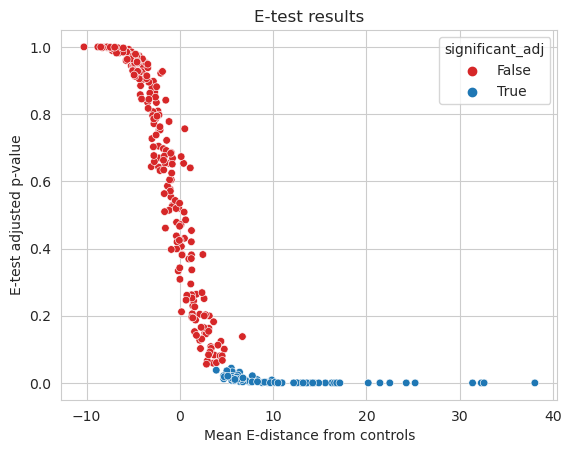

In [33]:
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:blue', False: 'tab:red'}, s=30)
pl.title('E-test results')
pl.xlabel('Mean E-distance from controls')
pl.ylabel('E-test adjusted p-value')
pl.show()

In [34]:
meta2 = adata.obs
meta2

orig.ident  nCount_RNA  nFeature_RNA sample  \
miR_3:TGACTCCGTCGAGTGA-1        miR     57468.0          7408  miR_3   
miR_2:GGAACCCTCCTACAAG-1        miR     23409.0          5177  miR_2   
miR_3:GGTGAAGTCGAACGGA-1        miR     82751.0          8199  miR_3   
miR_1:AGCCACGCACCTCGTT-1        miR    144464.0         10285  miR_1   
miR_1:TCCACCACATCAGTCA-1        miR     31627.0          6387  miR_1   
...                             ...         ...           ...    ...   
miR_3:GCCTGTTAGATGCTAA-1        miR     91092.0          9554  miR_3   
miR_2:GCGTGCACATAATCGC-1        miR     29984.0          5777  miR_2   
miR_2:AGGATAATCGCAGTTA-1        miR     38137.0          6405  miR_2   
miR_3:GGAAGTGAGAGCTGCA-1        miR     74000.0          8895  miR_3   
miR_1:CGTGAATGTGATACCT-1        miR     29116.0          6215  miR_1   

                                   barcode        guide       lor  \
miR_3:TGACTCCGTCGAGTGA-1  TGACTCCGTCGAGTGA    TuD_NC_01  3.932891   
miR_2:GGAACCCTCCTACAAG-1  GGAACCCTCCTACAAG    TuD_NC_01  3.102560   
miR_3:GGTGAAGTCGAACGGA-1  GGTGAAGTCGAACGGA    TuD_NC_01  5.074465   
miR_1:AGCCACGCACCTCGTT-1  AGCCACGCACCTCGTT    TuD_NC_01  3.214156   
miR_1:TCCACCACATCAGTCA-1  TCCACCACATCAGTCA    TuD_NC_01  1.060372   
...                                    ...          ...       ...   
miR_3:GCCTGTTAGATGCTAA-1  GCCTGTTAGATGCTAA  miR-4742-3p  1.380606   
miR_2:GCGTGCACATAATCGC-1  GCGTGCACATAATCGC  miR-4742-3p  0.671712   
miR_2:AGGATAATCGCAGTTA-1  AGGATAATCGCAGTTA  miR-4742-3p  6.441211   
miR_3:GGAAGTGAGAGCTGCA-1  GGAAGTGAGAGCTGCA  miR-4742-3p  6.882166   
miR_1:CGTGAATGTGATACCT-1  CGTGAATGTGATACCT  miR-4742-3p  6.066587   

                                 pvalue     adj_pvalue  max_umi  ...  \
miR_3:TGACTCCGTCGAGTGA-1   2.261580e-49   1.810958e-42     52.0  ...   
miR_2:GGAACCCTCCTACAAG-1   1.369852e-39   1.425708e-32     35.0  ...   
miR_3:GGTGAAGTCGAACGGA-1  5.135852e-102   4.112528e-95     98.0  ...   
miR_1:AGCCACGCACCTCGTT-1   8.024023e-34   8.098272e-27     37.0  ...   
miR_1:TCCACCACATCAGTCA-1   1.829491e-13   1.846420e-06     13.0  ...   
...                                 ...            ...      ...  ...   
miR_3:GCCTGTTAGATGCTAA-1  1.326897e-318  1.062512e-311    152.0  ...   
miR_2:GCGTGCACATAATCGC-1   7.755481e-08   8.071713e-01      2.0  ...   
miR_2:AGGATAATCGCAGTTA-1  4.940656e-324  5.142113e-317    135.0  ...   
miR_3:GGAAGTGAGAGCTGCA-1  4.940656e-324  3.956226e-317    300.0  ...   
miR_1:CGTGAATGTGATACCT-1  5.291763e-230  5.340730e-223     94.0  ...   

                             m_umi       v_umi  log_max_umi  log_n_umi  \
miR_3:TGACTCCGTCGAGTGA-1  0.360202    6.993665     1.716003   2.155336   
miR_2:GGAACCCTCCTACAAG-1  0.161209    3.160815     1.544068   1.806180   
miR_3:GGTGAAGTCGAACGGA-1  0.544081   24.349693     1.991226   2.334454   
miR_1:AGCCACGCACCTCGTT-1  0.221662    3.546701     1.568202   1.944483   
miR_1:TCCACCACATCAGTCA-1  0.080605    0.483385     1.113943   1.505150   
...                            ...         ...          ...        ...   
miR_3:GCCTGTTAGATGCTAA-1  0.836272   71.556459     2.181844   2.521138   
miR_2:GCGTGCACATAATCGC-1  0.012594    0.017518     0.301030   0.698970   
miR_2:AGGATAATCGCAGTTA-1  0.460957   45.976376     2.130334   2.262451   
miR_3:GGAAGTGAGAGCTGCA-1  1.002519  226.563125     2.477121   2.599883   
miR_1:CGTGAATGTGATACCT-1  0.309824   22.295181     1.973128   2.089905   

                          log_m_umi  percent.mt  integrated_snn_res.0.5  \
miR_3:TGACTCCGTCGAGTGA-1  -0.443454    7.002158                       1   
miR_2:GGAACCCTCCTACAAG-1  -0.792611    6.736725                       7   
miR_3:GGTGAAGTCGAACGGA-1  -0.264337    6.943723                       7   
miR_1:AGCCACGCACCTCGTT-1  -0.654308    4.953483                       7   
miR_1:TCCACCACATCAGTCA-1  -1.093641    5.280298                       5   
...                             ...         ...                     ...   
miR_3:GCCTGTTAGATGCTAA-1  -0.077652    7.151012     

In [35]:
nn = pd.DataFrame(adata.obsm['X_umap'])

In [36]:
nn3 = pd.DataFrame(adata.obsm['X_pca'])

In [37]:
%%R -i meta2
library(stringr)
set.seed(5)
control_idxs = which(str_sub(meta2$guide, start = 1, end = 6) == 'TuD_NC')
control_idxs = sample(control_idxs, 50)

far_guide_of_interest = 'hsa-miR-15b-3p'
far_guide <- rep('other_miR', nrow(meta2))
far_guide[which(meta2$guide == far_guide_of_interest)] <- far_guide_of_interest
far_guide[control_idxs] <- 'control'

close_guide_of_interest = 'hsa-miR-23b-5p'
close_guide <- rep('other_miR', nrow(meta2))
close_guide[which(meta2$guide == close_guide_of_interest)] <- close_guide_of_interest
close_guide[control_idxs] <- 'control'

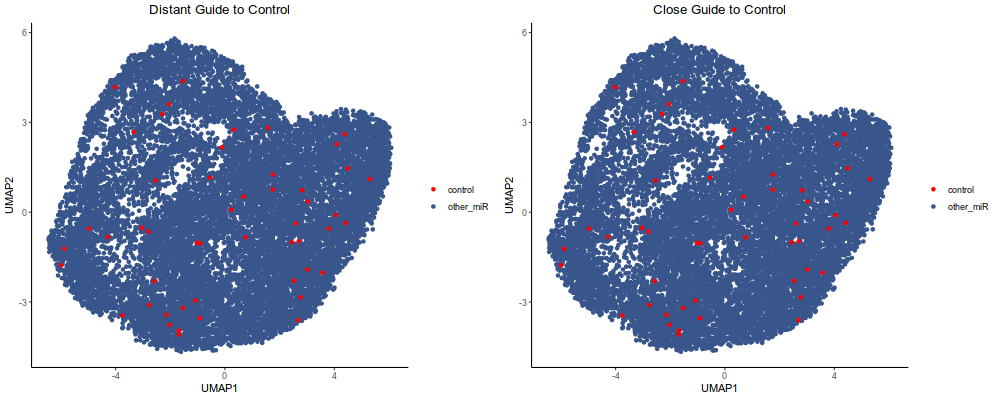

In [38]:
%%R -i nn -h 400 -w 1000

## showing the most distant and least distant pertubation to control
library(dplyr)
library(ggpubr)


nn2 = cbind(nn[,1:2], labs = far_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
a <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn2 = cbind(nn[,1:2], labs = close_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
b <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)

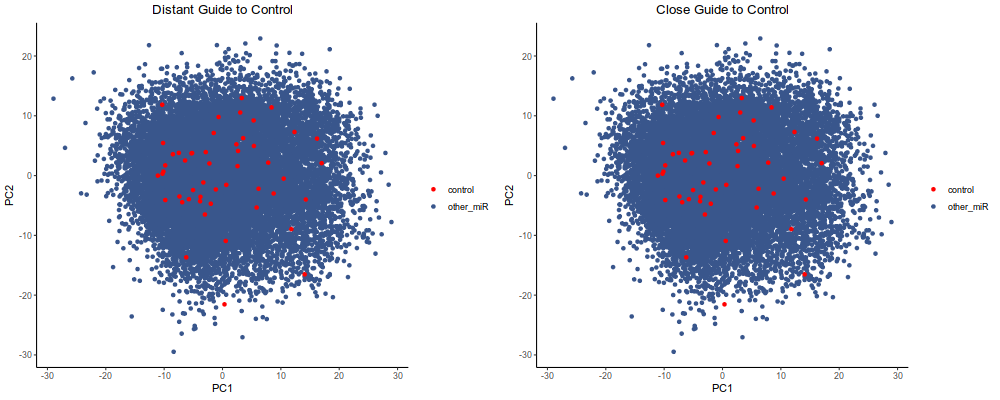

In [39]:
%%R -i nn3 -h 400 -w 1000
## showing the most distant and least distant pertubation to control

nn4 = cbind(nn3[,1:2], labs = far_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
a <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn4 = cbind(nn3[,1:2], labs = close_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
b <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)